In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import cirq
import qutip as qt
import optim
import torch as torch

2021-11-25 15:41:42.345239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 15:41:42.345276: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Any computational object that can apply quantum operations and return a measurement value is called a quantum device.

In PennyLane, a device could be a hardware device (such as the IBM QX4, via the PennyLane-PQ plugin), or a software simulator (such as Strawberry Fields, via the PennyLane-SF plugin).


In [2]:
dev = qml.device('default.qubit', wires=1)

Unitary = arbitrary rotation


In [3]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
##phi = 0
##theta = 0
##omega = 0
angles = [phi,theta,omega]

def real(angles, **kwargs):
    qml.Rot(*angles, wires=0)
        

Generator

In [4]:
def generator(w, **kwargs):
    qml.RZ(w[0], wires=0)
    qml.RY(w[1], wires=0)
    qml.RZ(w[2], wires=0)

Discriminators: DI chooses the input, DO is standard


In [5]:
def DI(w):
    qml.RX(w[0], wires=0)
    qml.RY(w[1], wires=0)
    qml.RZ(w[2], wires=0)

def DO(w):
    qml.RZ(w[0], wires=0)
    qml.RY(w[1], wires=0)
    qml.RZ(w[2], wires=0)


2 nodes:  1 for data-discriminator
          1 for generator-discriminator
          

In [6]:
@qml.qnode(dev, interface="torch", diff_method = 'parameter-shift')
def real_disc_circuit(angles, disc_weights):
    DI(disc_weights[0:3])
    real(angles)
    DO(disc_weights[3:6])
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch", diff_method = 'parameter-shift')
def gen_disc_circuit(gen_weights, disc_weights):
    DI(disc_weights[0:3])
    generator(gen_weights)
    DO(disc_weights[3:6])
    return qml.expval(qml.PauliZ(0))

##grad computing node, bc the pytorch interface does strange stuff
@qml.qnode(dev, diff_method = 'parameter-shift')
def real_disc_circuit_grad(angles, disc_weights):
    DI(disc_weights[0:3])
    real(angles)
    DO(disc_weights[3:6])
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method = 'parameter-shift')
def gen_disc_circuit_grad(gen_weights, disc_weights):
    DI(disc_weights[0:3])
    generator(gen_weights)
    DO(disc_weights[3:6])
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method = 'parameter-shift')
def real_circuit(angles):
    real(angles)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method = 'parameter-shift')
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.expval(qml.PauliZ(0))


Cost Functions

In [7]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(angles, disc_weights)
    
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(disc_weights, gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

Metrics:

In [8]:
get_real_matrix = qml.transforms.get_unitary_matrix(real_circuit)
get_gen_matrix  = qml.transforms.get_unitary_matrix(gen_circuit)

def HS_distance(angles, gen_weights):
    R = get_real_matrix(angles)
    G = get_gen_matrix(gen_weights)

    return np.trace((R-G).dot(np.transpose(np.conjugate(R-G))))



Training Initialization:

In [9]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))
init_disc_weights = np.random.normal(size=(6,))

gen_weights_grad  = torch.tensor(init_gen_weights, requires_grad=True)
disc_weights_grad = torch.tensor(init_disc_weights, requires_grad=True)

Running training

In [10]:
#----- training params --------------------
N = 300    #Number of training cycles
steps = 1  #Number of steps for generator training
ratio = 5  #gen/disc training ratio

#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance

#------------------------------------------
for i in range (N):
    
    #training discriminator
    gen_weights_non_grad = torch.tensor(gen_weights_grad.detach().numpy(), requires_grad = False)
    opt = optim.OAdam([disc_weights_grad, gen_weights_non_grad], lr = 0.1)
    
    def closure():
        opt.zero_grad()
        loss = disc_cost(disc_weights_grad, gen_weights_non_grad)
        
        disc_weights=np.array( list(disc_weights_grad.detach().numpy()) ,    requires_grad=True )
        gen_weights =np.array( list(gen_weights_non_grad.detach().numpy()) , requires_grad=False)
        
        grad_gen_circuit_disc  = qml.grad(gen_disc_circuit_grad,  argnum=1)
        grad_real_disc_circuit = qml.grad(real_disc_circuit_grad, argnum=1) 
        grad_fn_disc           = grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(angles, disc_weights)

        disc_weights_grad.grad = torch.tensor(grad_fn_disc)
        return loss

    for j in range(steps*ratio):
        opt.step(closure)
        if (j+1)%5==0:
            print('step : ',j, ' discriminator cost : ',disc_cost(disc_weights_grad, gen_weights_non_grad).item())
    print('discriminator trained')
    
    #training generator
    disc_weights_non_grad = torch.tensor(disc_weights_grad.detach().numpy(), requires_grad = False)
    opt = optim.OAdam([disc_weights_non_grad, gen_weights_grad], lr = 0.1)

    def closure():
        opt.zero_grad()
        loss = gen_cost(disc_weights_non_grad, gen_weights_grad)
        
        disc_weights=np.array( list(disc_weights_grad.detach().numpy()) ,    requires_grad=False)
        gen_weights =np.array( list(gen_weights_non_grad.detach().numpy()) , requires_grad=True)
        
        grad_fn_gen=-qml.grad(gen_disc_circuit_grad, argnum=0)(gen_weights, disc_weights)
        
        gen_weights_grad.grad = torch.tensor(grad_fn_gen)

        return loss

    for j in range(steps):
        opt.step(closure)
        if (j+1)%5==0:
            print('step : ',j, ' generator cost : ',gen_cost(disc_weights_non_grad, gen_weights_grad).item())
    
    Disc_cost += [disc_cost(disc_weights_grad, gen_weights_non_grad).item()]
    Gen_cost  += [gen_cost(disc_weights_non_grad, gen_weights_grad).item()]
    gen_weights = gen_weights_grad.detach().numpy()
    TrD = HS_distance(angles,gen_weights)
    print(TrD)
    Trace_d = Trace_d + [TrD]
    print('end of cycle number : ', i+1)


/home/rezen/Projects/QML/code/optim.py:95: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.data.addcdiv_(step_size, exp_avg, exp_avg_sq.sqrt().add(group['eps']))


step :  4  discriminator cost :  -0.8036738506679799
discriminator trained
(3.2516854384682023+0j)
end of cycle number :  1
step :  4  discriminator cost :  -0.9792162597774459
discriminator trained
(2.7125707901946745+0j)
end of cycle number :  2
step :  4  discriminator cost :  -0.9438439556002617
discriminator trained
(2.255778297562226+0j)
end of cycle number :  3
step :  4  discriminator cost :  -0.8990146319196479
discriminator trained
(1.894556578218448+0j)
end of cycle number :  4
step :  4  discriminator cost :  -0.8494709866327175
discriminator trained
(1.5367062439138541+0j)
end of cycle number :  5
step :  4  discriminator cost :  -0.7871789272713318
discriminator trained
(1.2963016999992005+0j)
end of cycle number :  6
step :  4  discriminator cost :  -0.73542564751417
discriminator trained
(1.2079935068308019+0j)
end of cycle number :  7
step :  4  discriminator cost :  -0.7156436207995356
discriminator trained
(1.1860015479602346+0j)
end of cycle number :  8
step :  4  d

step :  4  discriminator cost :  -0.11600015759487114
discriminator trained
(0.014722742663625072+0j)
end of cycle number :  66
step :  4  discriminator cost :  -0.02355980368619015
discriminator trained
(0.04224908888212546+0j)
end of cycle number :  67
step :  4  discriminator cost :  -0.077773943435821
discriminator trained
(0.02915938131236088+0j)
end of cycle number :  68
step :  4  discriminator cost :  -0.07351422200437896
discriminator trained
(0.05711732160476951+0j)
end of cycle number :  69
step :  4  discriminator cost :  -0.06377821371986125
discriminator trained
(0.10604967302129525+0j)
end of cycle number :  70
step :  4  discriminator cost :  -0.1574946130517243
discriminator trained
(0.11238990278273506+0j)
end of cycle number :  71
step :  4  discriminator cost :  -0.2176848077109676
discriminator trained
(0.014722752284207136+0j)
end of cycle number :  72
step :  4  discriminator cost :  -0.08439936392185887
discriminator trained
(0.02790183241828524+0j)
end of cycle

step :  4  discriminator cost :  -0.056354739006105437
discriminator trained
(0.039988442876318364+0j)
end of cycle number :  131
step :  4  discriminator cost :  -0.07227983213831646
discriminator trained
(0.014722891235750874+0j)
end of cycle number :  132
step :  4  discriminator cost :  -0.025389669043670793
discriminator trained
(0.0279013440091046+0j)
end of cycle number :  133
step :  4  discriminator cost :  -0.08570657382909941
discriminator trained
(0.029159403832381615+0j)
end of cycle number :  134
step :  4  discriminator cost :  -0.009758265437262104
discriminator trained
(0.042251546006988785+0j)
end of cycle number :  135
step :  4  discriminator cost :  -0.12270128133008873
discriminator trained
(0.029159483845164633+0j)
end of cycle number :  136
step :  4  discriminator cost :  -0.060566547202388965
discriminator trained
(0.03998874275787887+0j)
end of cycle number :  137
step :  4  discriminator cost :  -0.10972616815661074
discriminator trained
(0.02915947792246123

step :  4  discriminator cost :  -0.034060157665170454
discriminator trained
(0.027901127905698927+0j)
end of cycle number :  195
step :  4  discriminator cost :  -0.10627388166220397
discriminator trained
(0.01472192859035877+0j)
end of cycle number :  196
step :  4  discriminator cost :  -0.0325213010615365
discriminator trained
(0.02790106037637772+0j)
end of cycle number :  197
step :  4  discriminator cost :  -0.10780050866387192
discriminator trained
(0.014721966605492015+0j)
end of cycle number :  198
step :  4  discriminator cost :  -0.03043971920193922
discriminator trained
(0.02790098362934231+0j)
end of cycle number :  199
step :  4  discriminator cost :  -0.10987920966661602
discriminator trained
(0.014722008871508995+0j)
end of cycle number :  200
step :  4  discriminator cost :  -0.013236345652447024
discriminator trained
(0.057119209142522887+0j)
end of cycle number :  201
step :  4  discriminator cost :  -0.16066910139749768
discriminator trained
(0.014721973964403124+0

step :  4  discriminator cost :  -0.03689394218392561
discriminator trained
(0.057070196733196354+0j)
end of cycle number :  259
step :  4  discriminator cost :  -0.09640404949353998
discriminator trained
(0.029152210875720716+0j)
end of cycle number :  260
step :  4  discriminator cost :  -0.0721890171323859
discriminator trained
(0.027933744888519553+0j)
end of cycle number :  261
step :  4  discriminator cost :  -0.1176616414002456
discriminator trained
(0.014714898069805336+0j)
end of cycle number :  262
step :  4  discriminator cost :  -0.021162853757055067
discriminator trained
(0.05707081971964735+0j)
end of cycle number :  263
step :  4  discriminator cost :  -0.14795880409507656
discriminator trained
(0.014714896675823758+0j)
end of cycle number :  264
step :  4  discriminator cost :  -0.0500025366834439
discriminator trained
(0.02793377117857251+0j)
end of cycle number :  265
step :  4  discriminator cost :  -0.10233267083016784
discriminator trained
(0.014714864961242996+0j)

In [13]:
print("Prob(real classified as real): ", prob_real_true(disc_weights_grad).item())

Prob(real classified as real):  0.9439181259213776


In [14]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights_grad, disc_weights_grad).item())


Prob(fake classified as real):  0.9502752810906074


Comparing output for |0> and printing tthe rotation params of the generator:

In [17]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights_grad.detach().numpy())))


Real Bloch vector: [0.90096887 0.43388374 0.        ]
Generator Bloch vector: [ 0.91661823  0.39837925 -0.03324149]


plot

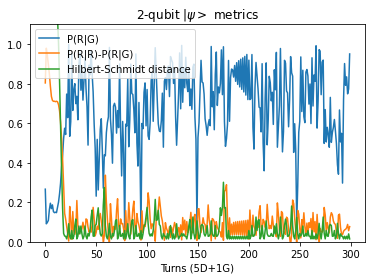

In [22]:
import matplotlib.pyplot as plt

Trace_d = np.array(Trace_d)
plt.plot(-np.array(Gen_cost), label='P(R|G)')
plt.plot(-np.array(Disc_cost), label='P(R|R)-P(R|G)')

plt.plot(np.real(Trace_d), label='Hilbert-Schmidt distance')

plt.ylim([0,1.1])
plt.xlabel('Turns (5D+1G)') 
plt.title("2-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('first_tomography.png')